## Setup

In [1]:
!pip install -qq diffusers matplotlib wandb transformers accelerate ftfy

In [ ]:
!pip install -qq -U diffusers datasets transformers accelerate ftfy

In [ ]:
!pip install onnxruntime==0.5

In [ ]:
import onnxruntime
onnxruntime.__version__

In [ ]:
!pip install onnxruntime-training

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import random
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cpu_count = os.cpu_count()
tensor2pil = torchvision.transforms.ToPILImage()
seed = 42

## MNIST

### Data

In [ ]:
batch_size = 8

dataset = torchvision.datasets.MNIST(root='./mnist',
                                     train=True,
                                     download=True,
                                     transform=torchvision.transforms.ToTensor())

train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
inputs, labels = next(iter(train_dl))
inputs.shape, labels.shape

In [ ]:
tensor2pil = torchvision.transforms.ToPILImage()

In [ ]:
display(tensor2pil(abs(torchvision.utils.make_grid(inputs) - 1)))

In [ ]:
plt.imshow(torchvision.utils.make_grid(inputs)[0], cmap='Greys')
plt.axis('off')
plt.show()

### Creating a class-conditioned UNet

In [ ]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_embed_size=4):
        super().__init__()
        
        # init embedding layer
        self.embedding_layer = nn.Embedding(num_classes, class_embed_size)
        
        # init UNet
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=class_embed_size + 1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=('DownBlock2D',
                              'AttnDownBlock2D',
                              'AttnDownBlock2D'),
            up_block_types=('AttnUpBlock2D',
                            'AttnUpBlock2D',
                            'UpBlock2D')
        )
    
    def forward(self, x, timestep, class_labels):
        # batch_size, channels, height and width
        bs, ch, h, w = x.shape
        
        # compute class embeddings
        class_embeds = self.embedding_layer(class_labels)
        
        # reshape class embeddings
        class_embeds = class_embeds.view(*class_embeds.shape, 1, 1).expand(*class_embeds.shape, h, w)
        
        # concat input "x" and class embeddings across the channel dimension
        model_input = torch.cat((x, class_embeds), dim=1)
        
        # forward pass
        pred_noise = self.model(model_input, timestep).sample
        
        return pred_noise

In [ ]:
model = ClassConditionedUnet()
out = model(inputs, 0, labels)
out.shape

### Training

In [ ]:
epochs = 10

# define dataloader
batch_size = 128
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# init training scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# init model
model = ClassConditionedUnet().to(device)
model.train()

# define loss function
loss_fn = nn.MSELoss()

# define lr and optimizer
lr = 1e-3
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses = []

for epoch in tqdm(range(epochs)):
    for i, batch in enumerate(tqdm(train_dl)):
        inputs = (batch[0] * 2 - 1).to(device)
        labels = batch[1].to(device)
        
        batch_size = inputs.shape[0]
        noise = torch.randn_like(inputs).to(device)
        timesteps = torch.tensor([random.randint(0, noise_scheduler.num_train_timesteps-1) for _ in range(batch_size)]).to(device)
        noisy_inputs = noise_scheduler.add_noise(inputs, noise, timesteps)
        
        # forward pass
        noise_pred = model(noisy_inputs, timesteps, labels)
        
        # loss
        loss = loss_fn(noise_pred, noise)
        losses.append(loss.item())
        
        # backward pass
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        # optimizer zero grad
        optimizer.zero_grad()
        
        if (i + 1) % 25 == 0:
            print(f'step: {i + 1} | loss: {loss}')

In [ ]:
plt.plot(losses)
plt.show()

### Sampling

In [ ]:
inputs = torch.randn(80, 1, 28, 28).to(device)
labels = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

for i, timestep in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.inference_mode():
        noise_preds = model(inputs, timestep, labels)
    
    inputs = noise_scheduler.step(noise_preds, timestep, inputs).prev_sample

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.imshow(torchvision.utils.make_grid(inputs.cpu().clip(-1, 1))[0], cmap='Greys')
plt.axis('off')
plt.show()

## FashionMNIST

### Data

In [3]:
batch_size = 8

dataset = torchvision.datasets.FashionMNIST(root='./fashion_mnist',
                                            train=True,
                                            download=True,
                                            transform=torchvision.transforms.ToTensor())

train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



In [4]:
len(dataset.classes)

10

torch.Size([8, 1, 28, 28])


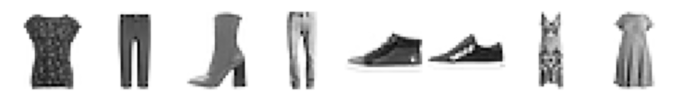

In [5]:
batch = next(iter(train_dl))
inputs, labels = batch
print(inputs.shape)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.imshow(torchvision.utils.make_grid(inputs)[0], cmap='Greys')
plt.axis('off')
plt.show()

### Creating a class-conditioned Unet

In [6]:
class ClassConditionedUNet(nn.Module):
    def __init__(self, num_classes=10, class_embed_size=4):
        super().__init__()
        
        # init emebedding layer
        self.embedding_layer = nn.Embedding(num_classes, class_embed_size)
        
        # init model
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=class_embed_size + 1,
            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),
            down_block_types=('DownBlock2D',
                              'AttnDownBlock2D',
                              'AttnDownBlock2D'),
            up_block_types=('AttnUpBlock2D',
                            'AttnUpBlock2D',
                            'UpBlock2D')
        )
        
    
    def forward(self, x, timestep, labels):
        # batch size, channels, height, width
        batch_size, ch, h, w = x.shape
        
        # compute class embeddings
        class_embeds = self.embedding_layer(labels)
        
        # reshape class embeddings
        class_embeds = class_embeds.view(*class_embeds.shape, 1, 1).expand(*class_embeds.shape, h, w)
        
        # concatenate input "x" and class embeddings together across channel dimension
        model_input = torch.cat((x, class_embeds), dim=1)
        
        # forward pass
        noise_pred = self.model(model_input, timestep)
        
        return noise_pred

In [7]:
model = ClassConditionedUNet()
out = model(x=inputs, timestep=0, labels=labels).sample
out.shape

torch.Size([8, 1, 28, 28])

### Training

In [8]:
epochs = 1

# dataloader
batch_size = 128
train_dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# training scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# model
model = ClassConditionedUNet().to(device)
model.train()

# lr & optimizer
lr = 1e-3
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lrs = []

# loss
loss_fn = nn.MSELoss()
losses = []


for epoch in tqdm(range(epochs)):
    for i, batch in enumerate(tqdm(train_dl, leave=False)):
        inputs = (batch[0] * 2 - 1).to(device)
        labels = batch[1].to(device)
        noise = torch.randn_like(inputs).to(device)
        
        # create random timesteps
        batch_size = inputs.shape[0]
        num_timesteps = noise_scheduler.num_train_timesteps
        timesteps = torch.tensor([random.randint(0, num_timesteps-1) for _ in range(batch_size)]).to(device)
        
        # add noise to inputs
        noisy_inputs = noise_scheduler.add_noise(inputs, noise, timesteps)
        
        # forward pass
        noise_pred = model(noisy_inputs, timesteps, labels).sample
        
        # loss
        loss = loss_fn(noise_pred, noise)
        losses.append(loss.item())
        
        # backward pass
        loss.backward()
        
        # optimizer step
        optimizer.step()
        
        # optimizer zero grad
        optimizer.zero_grad()
        
    # lr scheduler step
    lrs.append(optimizer.param_groups[0]['lr'])
    lr_scheduler.step()
    
    epoch_avg_loss = sum(losses[-len(train_dl):]) / len(train_dl)
    print(f'epoch: {epoch+1} | loss: {epoch_avg_loss}')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

epoch: 1 | loss: 0.11589805076498466


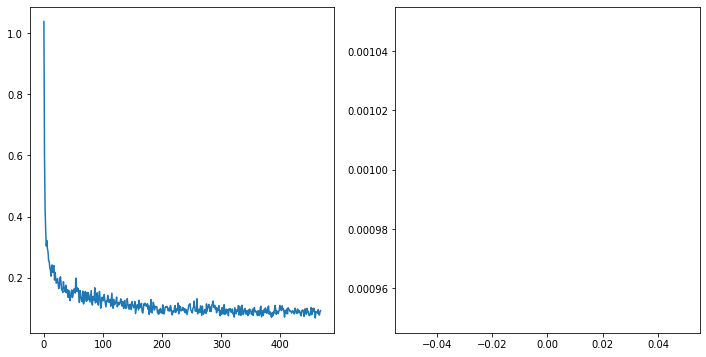

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(losses)
axs[1].plot(lrs)
plt.show()

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline.save_pretrained('./pretrained_1epoch')

### Sampling

In [ ]:
generator = torch.Generator(device=device).manual_seed(seed)
x = torch.randn((80, 1, 28, 28), device=device, generator=generator)
labels = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

for i, timestep in enumerate(tqdm(noise_scheduler.timesteps)):
    with torch.inference_mode():
        noise_pred = model(x, timestep, labels).sample
    
    x = noise_scheduler.step(noise_pred, timestep, x, generator=generator).prev_sample

In [ ]:
pred_images = torchvision.transforms.functional.invert(((x.cpu().clip(-1, 1) + 1) / 2))
pred_images = [tensor2pil(image) for image in pred_images]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
plt.imshow(torchvision.utils.make_grid(x.cpu().clip(-1, 1))[0], cmap='Greys')
plt.axis('off')
plt.show()

### Sampling (pipeline)

In [ ]:
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
images = pipeline(batch_size=4)

### Accelerate

In [ ]:
PROJECT_NAME = 'fashion_mnist_diffusers'
MODEL_NAME = 'fashion_mnist_class_cond_unet'

In [ ]:
dataset = torchvision.datasets.FashionMNIST(root='./fashion_mnist',
                                            train=True,
                                            download=True,
                                            transform=torchvision.transforms.ToTensor())

In [ ]:
!accelerate launch --mixed_precision=fp16 fashionmnist_accelerate.py \
    --project_name={PROJECT_NAME} \
    --output_dir={PROJECT_NAME} \
    --ddpm_beta_schedule='squaredcos_cap_v2' \
    --dataset_name=None \
    --train_data_dir=None \
    --dataset_sample_size=100 \
    --seed=2077 \
    --resolution=28 \
    --output_dir={MODEL_NAME} \
    --train_batch_size=128 \
    --eval_batch_size=8 \
    --num_epochs=10 \
    --gradient_accumulation_steps=1 \
    --learning_rate=4e-4 \
    --lr_scheduler="cosine" \
    --lr_warmup_steps=500 \
    --mixed_precision="fp16" \
    --save_images_epochs=1 \
    --save_model_epochs=1 \
    --push_to_wandb